In [ ]:
from TraceSimulator import NoiseGenerator
import numpy as np
import yaml
from pathlib import Path
from trace_IO import save_traces_to_zstd

# YAML configuration string
yaml_str = """
LCE: '/ceph/bmaier/delight/share/TraceSimulator/optical/optSim_LCE.npz'
optArrivalTime: '/ceph/bmaier/delight/share/TraceSimulator/optical/optSim_arrivalTime.npz'
PCE: '/ceph/bmaier/delight/share/TraceSimulator/acoustic/phonSim_PCE.npz'
phonArrivalTime: '/ceph/bmaier/delight/share/TraceSimulator/acoustic/phonSim_phonTemplate.npz'
TCE: '/ceph/bmaier/delight/share/TraceSimulator/triplet/trSim_TCE.npz'
trArrivalTime: '/ceph/bmaier/delight/share/TraceSimulator/triplet/trSim_trTemplate.npz'
positionMMC: '/ceph/bmaier/delight/share/TraceSimulator/position_MMC.dat'
sampling_frequency: 3906250
trace_samples: 32768
noise_type: 'white'
noise_power: 33.2
"""

# Load configuration
base_config = yaml.safe_load(yaml_str)

# Parameters
noise_types = ['white', 'pink', 'brownian', 'blue', 'violet']
n_batches = 100
batch_size = 54
trace_length = base_config["trace_samples"]

# Output directory
output_base_dir = Path("/ceph/dwong/trigger_samples/noise_traces")
output_base_dir.mkdir(parents=True, exist_ok=True)

for noise in noise_types:
    print(f"\nGenerating {n_batches * batch_size} traces of {noise} noise...")

    # Update config
    config = base_config.copy()
    config['noise_type'] = noise
    ng = NoiseGenerator(config)

    # Preallocate array with shape (100, 54, 32768)
    all_traces = np.empty((n_batches, batch_size, trace_length), dtype=np.float32)

    for b in range(n_batches):
        for i in range(batch_size):
            all_traces[b, i] = ng.generate_noise(trace_length)
    # Save all traces in a single .zst file
    output_path = output_base_dir / f"{noise}_noise_traces.zst"
    save_traces_to_zstd(all_traces, output_path)



Generating 5400 traces of white noise...

Generating 5400 traces of pink noise...

Generating 5400 traces of brownian noise...

Generating 5400 traces of blue noise...

Generating 5400 traces of violet noise...

Generating 5400 traces of /ceph/dwong/delight/templates/noise_psd_xray.npy noise...


In [28]:
import yaml
import numpy as np
import zstandard as zstd
import os
from TraceSimulator import TraceSimulator

def read_yaml_to_dict(file_path):
    with open(file_path, 'r') as file:
        config_dict = yaml.safe_load(file)
    return config_dict

config = read_yaml_to_dict('../archive/config.yaml')
ts = TraceSimulator(config)
energy = 0
n_sets = 100
all_traces = []
for _ in range(n_sets):
    trace = ts.generate(E=energy, x=-40, y=80, z=-1800, no_noise=False, type_recoil='NR', quantize=True, phonon_only=False)
    
    all_traces.append(np.asarray(trace[0], dtype=np.float16))

save_traces_to_zstd(all_traces, f"/ceph/dwong/trigger_samples/noise_traces/mmc_noise_traces.zst")

In [22]:
from OF_trigger import *

sampling_frequency = 3906250


template = np.load("../templates/template_K_alpha_no_baseline.npy")
noise_psd = np.load("../templates/noise_psd_from_MMC.npy")
trace_path = "/ceph/dwong/trigger_samples/traces_energy_0.zst"
# Parameters

# Initialize Optimum Filter
trigger = OFtrigger(template, noise_psd, sampling_frequency)


--- Processing white noise ---
OF Amplitude:
  Mean: 0.0029
  Std:  0.1638
  Min:  -0.5421
  Max:  0.5736

Chi²:
  Mean: 0.4905
  Std:  0.0001
  Min: 0.4904
  Max: 0.4906


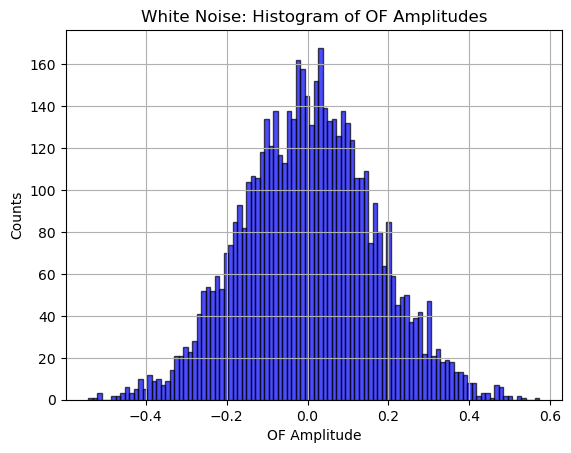

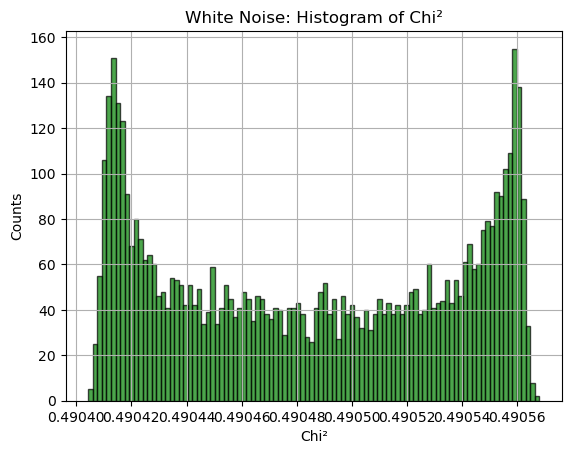

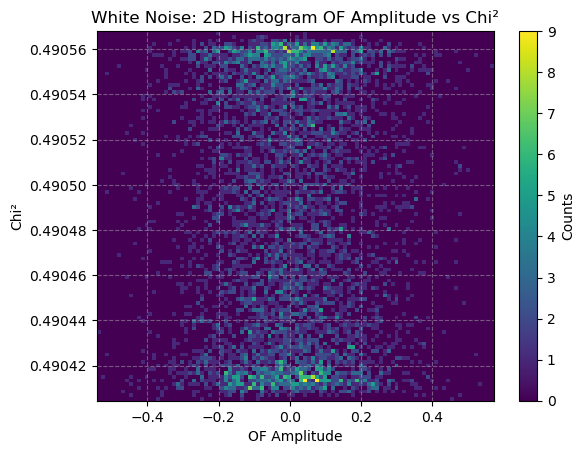


--- Processing pink noise ---
OF Amplitude:
  Mean: -0.0055
  Std:  2.9246
  Min:  -9.7539
  Max:  9.2779

Chi²:
  Mean: 0.1188
  Std:  0.0001
  Min: 0.1178
  Max: 0.1189


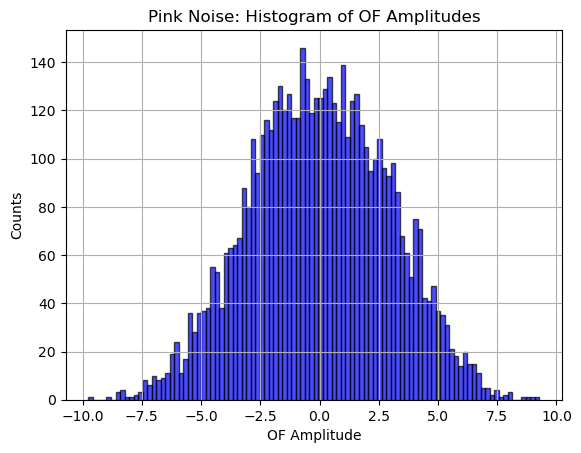

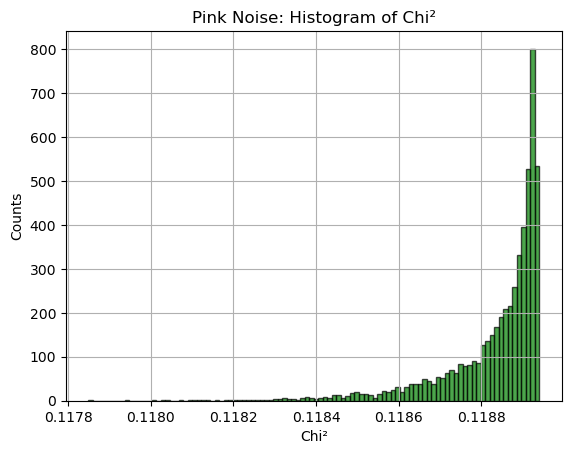

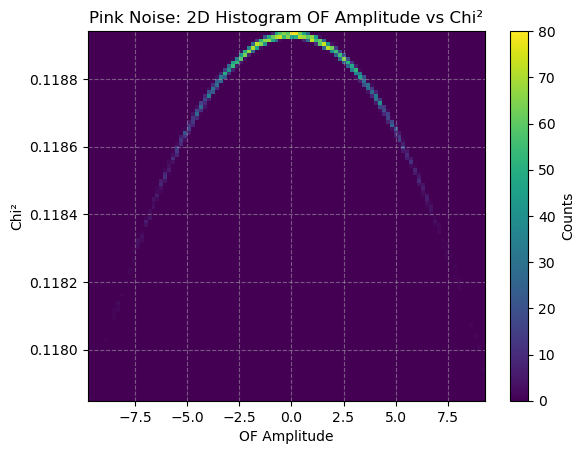


--- Processing brownian noise ---
OF Amplitude:
  Mean: -0.0417
  Std:  7.1250
  Min:  -18.8712
  Max:  16.0824

Chi²:
  Mean: 0.0082
  Std:  0.0006
  Min: 0.0047
  Max: 0.0088


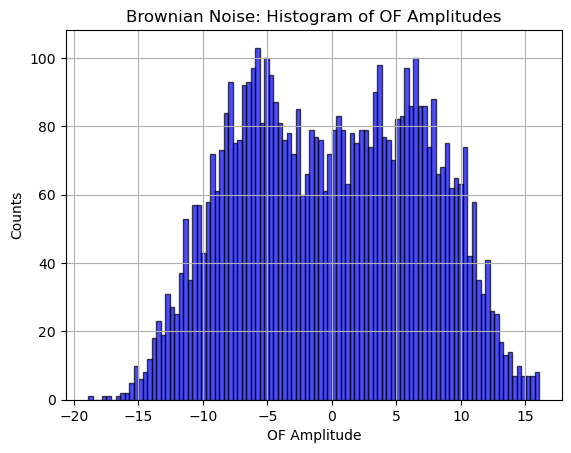

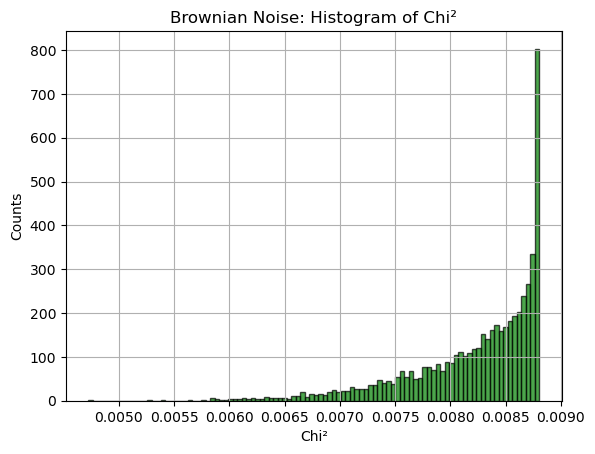

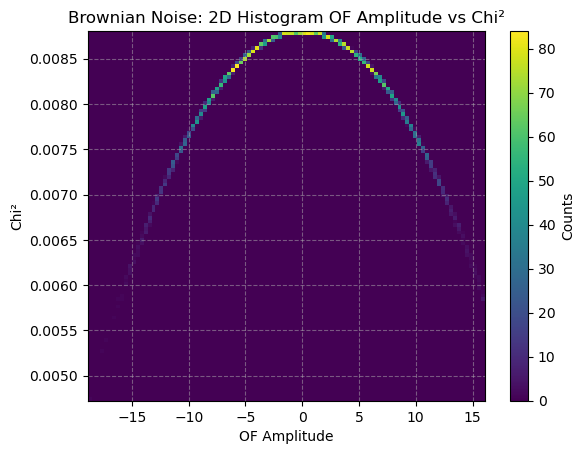


--- Processing blue noise ---
OF Amplitude:
  Mean: -0.0003
  Std:  0.0481
  Min:  -0.1831
  Max:  0.1641

Chi²:
  Mean: 0.6948
  Std:  0.0001
  Min: 0.6947
  Max: 0.6950


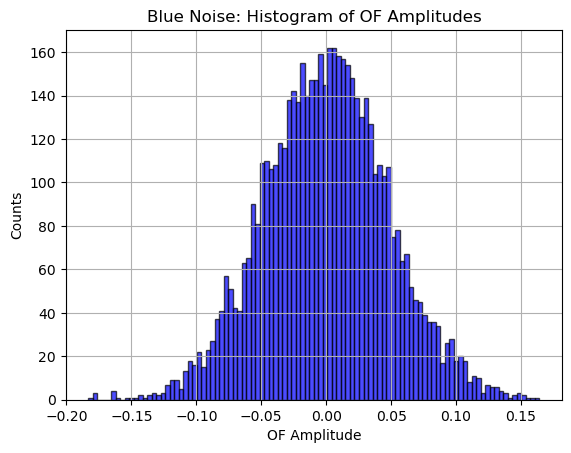

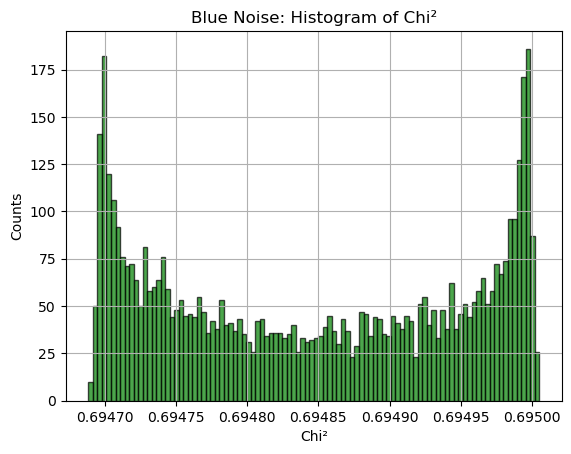

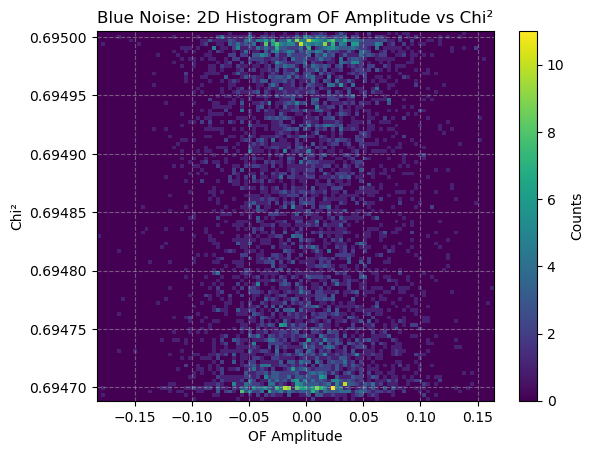


--- Processing violet noise ---
OF Amplitude:
  Mean: 0.0009
  Std:  0.0516
  Min:  -0.2161
  Max:  0.1848

Chi²:
  Mean: 0.8220
  Std:  0.0002
  Min: 0.8217
  Max: 0.8222


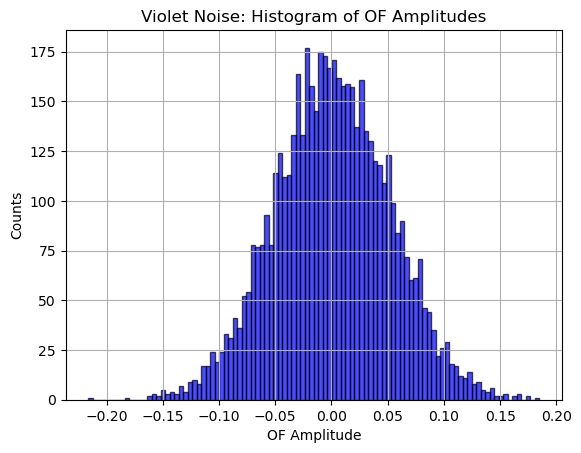

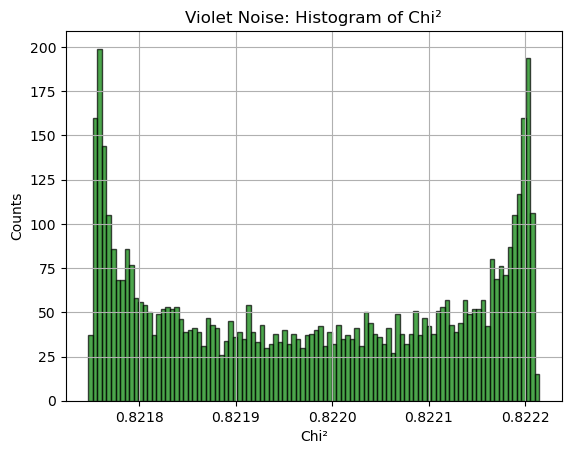

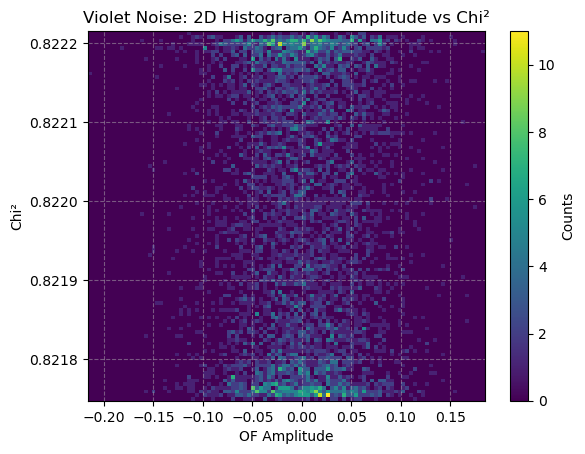


--- Processing mmc noise ---
OF Amplitude:
  Mean: 0.0177
  Std:  0.7631
  Min:  -2.4861
  Max:  2.7128

Chi²:
  Mean: 0.2176
  Std:  0.0002
  Min: 0.2168
  Max: 0.2186


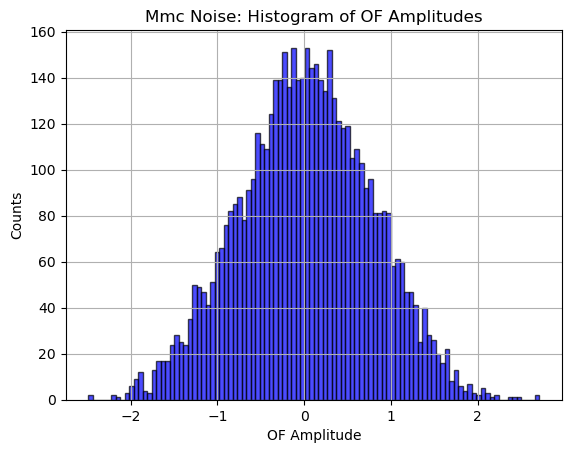

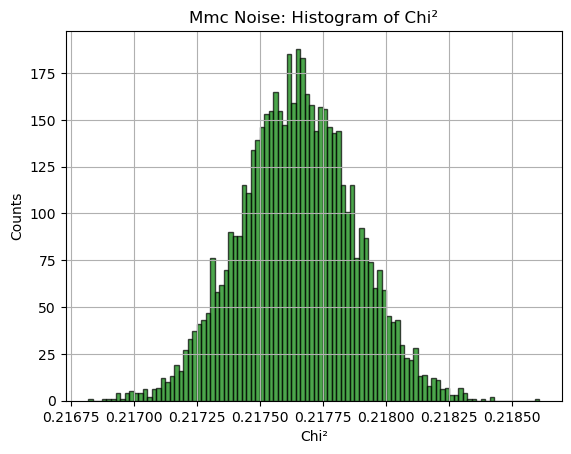

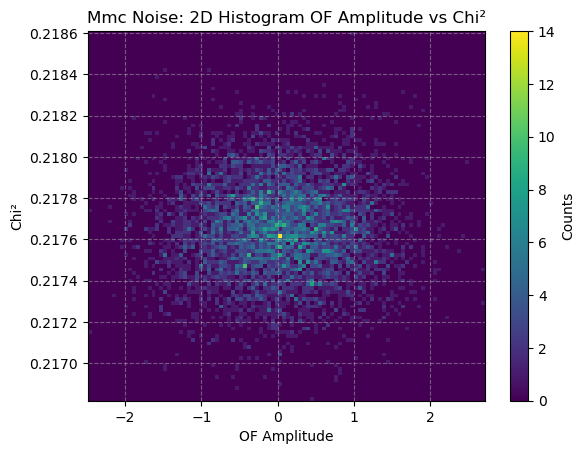

In [29]:
from OF_trigger import *

# Assume `trigger` is already defined and provides trigger.fit(trace)
# Define noise types
noise_colors = ['white', 'pink', 'brownian', 'blue', 'violet', 'mmc']
base_path = "/ceph/dwong/trigger_samples/noise_traces"

n_sets = 100  # number of 54-trace batches to use
trace_per_set = 54

for color in noise_colors:
    print(f"\n--- Processing {color} noise ---")

    # Load traces
    path = f"{base_path}/{color}_noise_traces.zst"
    loaded_traces = load_traces_from_zstd(path, n_traces=n_sets)

    # Run trigger fitting
    of_amplitudes_all = []
    chisq_all = []

    for i in range(n_sets):
        for trace in loaded_traces[i]:
            of_val, chisq = trigger.fit(trace)
            of_amplitudes_all.append(of_val)
            chisq_all.append(chisq)

    # Convert to arrays
    of_amplitudes_all = np.array(of_amplitudes_all)
    chisq_all = np.array(chisq_all)

    # --- Statistics ---
    print("OF Amplitude:")
    print(f"  Mean: {np.mean(of_amplitudes_all):.4f}")
    print(f"  Std:  {np.std(of_amplitudes_all):.4f}")
    print(f"  Min:  {np.min(of_amplitudes_all):.4f}")
    print(f"  Max:  {np.max(of_amplitudes_all):.4f}")

    print("\nChi²:")
    print(f"  Mean: {np.mean(chisq_all):.4f}")
    print(f"  Std:  {np.std(chisq_all):.4f}")
    print(f"  Min: {np.min(chisq_all):.4f}")
    print(f"  Max: {np.max(chisq_all):.4f}")

    # --- Plots ---
    plt.figure()
    plt.hist(of_amplitudes_all, bins=100, color='blue', alpha=0.7, edgecolor='black')
    plt.title(f"{color.capitalize()} Noise: Histogram of OF Amplitudes")
    plt.xlabel("OF Amplitude")
    plt.ylabel("Counts")
    plt.grid(True)

    plt.figure()
    plt.hist(chisq_all, bins=100, color='green', alpha=0.7, edgecolor='black')
    plt.title(f"{color.capitalize()} Noise: Histogram of Chi²")
    plt.xlabel("Chi²")
    plt.ylabel("Counts")
    plt.grid(True)

    plt.figure()
    plt.hist2d(of_amplitudes_all, chisq_all, bins=100, cmap='viridis')
    plt.colorbar(label='Counts')
    plt.xlabel('OF Amplitude')
    plt.ylabel('Chi²')
    plt.title(f"{color.capitalize()} Noise: 2D Histogram OF Amplitude vs Chi²")
    plt.grid(True, linestyle='--', alpha=0.5)

    plt.show()


In [30]:
from OF_trigger import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from trace_IO import load_traces_from_zstd

# Define noise types
noise_colors = ['white', 'pink', 'brownian', 'blue', 'violet', 'mmc']
base_path = "/ceph/dwong/trigger_samples/noise_traces"

n_sets = 100  # number of 54-trace batches to use
trace_per_set = 54

# Create a multi-page PDF
pdf_path = "of_trigger_analysis.pdf"
with PdfPages(pdf_path) as pdf:
    for color in noise_colors:
        print(f"\n--- Processing {color} noise ---")

        # Load traces
        path = f"{base_path}/{color}_noise_traces.zst"
        loaded_traces = load_traces_from_zstd(path, n_traces=n_sets)

        # Run trigger fitting
        of_amplitudes_all = []
        chisq_all = []

        for i in range(n_sets):
            for trace in loaded_traces[i]:
                of_val, chisq = trigger.fit(trace)
                of_amplitudes_all.append(of_val)
                chisq_all.append(chisq)

        # Convert to arrays
        of_amplitudes_all = np.array(of_amplitudes_all)
        chisq_all = np.array(chisq_all)

        # --- Statistics ---
        print("OF Amplitude:")
        print(f"  Mean: {np.mean(of_amplitudes_all):.4f}")
        print(f"  Std:  {np.std(of_amplitudes_all):.4f}")
        print(f"  Min:  {np.min(of_amplitudes_all):.4f}")
        print(f"  Max:  {np.max(of_amplitudes_all):.4f}")

        print("\nChi²:")
        print(f"  Mean: {np.mean(chisq_all):.4f}")
        print(f"  Std:  {np.std(chisq_all):.4f}")
        print(f"  Min: {np.min(chisq_all):.4f}")
        print(f"  Max: {np.max(chisq_all):.4f}")

        # --- Plot: Histogram of OF Amplitudes ---
        fig1 = plt.figure()
        plt.hist(of_amplitudes_all, bins=100, color='blue', alpha=0.7, edgecolor='black')
        plt.title(f"{color.capitalize()} Noise: Histogram of OF Amplitudes")
        plt.xlabel("OF Amplitude")
        plt.ylabel("Counts")
        plt.grid(True)
        pdf.savefig(fig1)
        plt.close(fig1)

        # --- Plot: Histogram of Chi² ---
        fig2 = plt.figure()
        plt.hist(chisq_all, bins=100, color='green', alpha=0.7, edgecolor='black')
        plt.title(f"{color.capitalize()} Noise: Histogram of Chi²")
        plt.xlabel("Chi²")
        plt.ylabel("Counts")
        plt.grid(True)
        pdf.savefig(fig2)
        plt.close(fig2)

        # --- Plot: 2D Histogram OF Amplitude vs Chi² ---
        fig3 = plt.figure()
        plt.hist2d(of_amplitudes_all, chisq_all, bins=100, cmap='viridis')
        plt.colorbar(label='Counts')
        plt.xlabel('OF Amplitude')
        plt.ylabel('Chi²')
        plt.title(f"{color.capitalize()} Noise: 2D Histogram OF Amplitude vs Chi²")
        plt.grid(True, linestyle='--', alpha=0.5)
        pdf.savefig(fig3)
        plt.close(fig3)

print(f"\nAll plots saved to: {pdf_path}")



--- Processing white noise ---
OF Amplitude:
  Mean: 0.0029
  Std:  0.1638
  Min:  -0.5421
  Max:  0.5736

Chi²:
  Mean: 0.4905
  Std:  0.0001
  Min: 0.4904
  Max: 0.4906

--- Processing pink noise ---
OF Amplitude:
  Mean: -0.0055
  Std:  2.9246
  Min:  -9.7539
  Max:  9.2779

Chi²:
  Mean: 0.1188
  Std:  0.0001
  Min: 0.1178
  Max: 0.1189

--- Processing brownian noise ---
OF Amplitude:
  Mean: -0.0417
  Std:  7.1250
  Min:  -18.8712
  Max:  16.0824

Chi²:
  Mean: 0.0082
  Std:  0.0006
  Min: 0.0047
  Max: 0.0088

--- Processing blue noise ---
OF Amplitude:
  Mean: -0.0003
  Std:  0.0481
  Min:  -0.1831
  Max:  0.1641

Chi²:
  Mean: 0.6948
  Std:  0.0001
  Min: 0.6947
  Max: 0.6950

--- Processing violet noise ---
OF Amplitude:
  Mean: 0.0009
  Std:  0.0516
  Min:  -0.2161
  Max:  0.1848

Chi²:
  Mean: 0.8220
  Std:  0.0002
  Min: 0.8217
  Max: 0.8222

--- Processing mmc noise ---
OF Amplitude:
  Mean: 0.0177
  Std:  0.7631
  Min:  -2.4861
  Max:  2.7128

Chi²:
  Mean: 0.2176
  Std:


--- Processing white noise ---

--- Processing pink noise ---

--- Processing brownian noise ---

--- Processing blue noise ---

--- Processing violet noise ---

--- Processing mmc noise ---


/tmp/ipykernel_1017449/291302817.py:19: MatplotlibDeprecationWarning: Keeping empty pdf files is deprecated since 3.8 and support will be removed in 3.10.
  with PdfPages(pdf_path) as pdf:


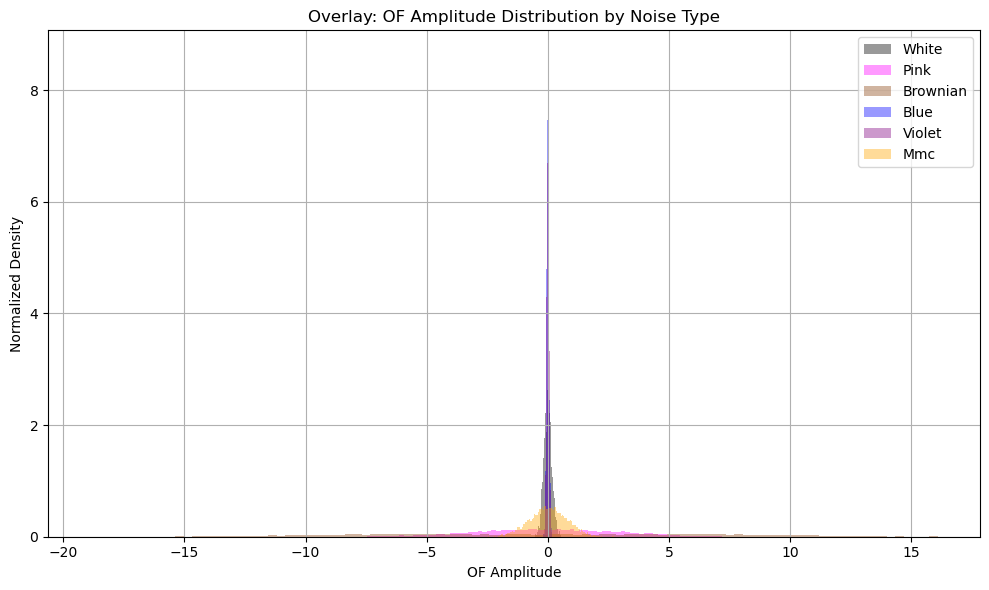

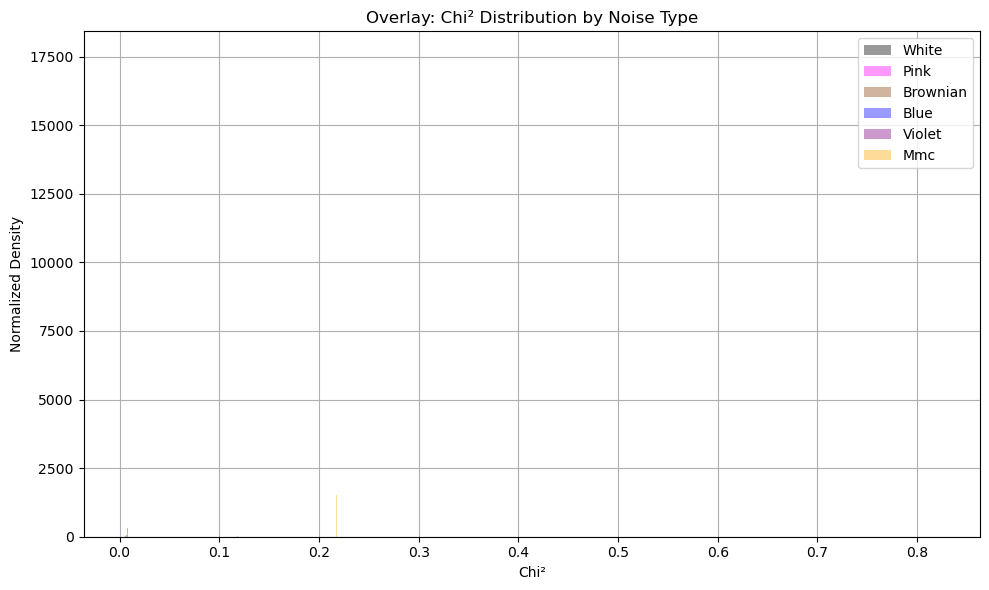

✅ Overlay plots saved as PNG images.


In [32]:
from OF_trigger import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from trace_IO import load_traces_from_zstd

# --- Configuration ---
noise_colors = ['white', 'pink', 'brownian', 'blue', 'violet', 'mmc']
base_path = "/ceph/dwong/trigger_samples/noise_traces"
n_sets = 100  # number of 54-trace batches
trace_per_set = 54
pdf_path = "of_trigger_analysis.pdf"

# --- Data Containers for Overlay ---
all_amplitudes = {}
all_chisq = {}

# --- Start PDF Writer ---
with PdfPages(pdf_path) as pdf:
    for color in noise_colors:
        print(f"\n--- Processing {color} noise ---")

        # Load traces
        path = f"{base_path}/{color}_noise_traces.zst"
        loaded_traces = load_traces_from_zstd(path, n_traces=n_sets)

        # Run trigger fitting
        of_amplitudes_all = []
        chisq_all = []

        for i in range(n_sets):
            for trace in loaded_traces[i]:
                of_val, chisq = trigger.fit(trace)
                of_amplitudes_all.append(of_val)
                chisq_all.append(chisq)

        of_amplitudes_all = np.array(of_amplitudes_all)
        chisq_all = np.array(chisq_all)

        # Store for overlay
        all_amplitudes[color] = of_amplitudes_all
        all_chisq[color] = chisq_all

# --- Overlay Plots ---
plot_colors = {
    'white': 'black',
    'pink': 'magenta',
    'brownian': 'saddlebrown',
    'blue': 'blue',
    'violet': 'purple',
    'mmc': 'orange',
}

# --- Overlay: OF Amplitudes ---
plt.figure(figsize=(10, 6))
for color, data in all_amplitudes.items():
    plt.hist(data, bins=100, alpha=0.4, label=color.capitalize(),
             color=plot_colors.get(color, 'gray'), edgecolor='none', density=True)
plt.title("Overlay: OF Amplitude Distribution by Noise Type")
plt.xlabel("OF Amplitude")
plt.ylabel("Normalized Density")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("overlay_of_amplitudes.png")
plt.show()

# --- Overlay: Chi² ---
plt.figure(figsize=(10, 6))
for color, data in all_chisq.items():
    plt.hist(data, bins=100, alpha=0.4, label=color.capitalize(),
             color=plot_colors.get(color, 'gray'), edgecolor='none', density=True)
plt.title("Overlay: Chi² Distribution by Noise Type")
plt.xlabel("Chi²")
plt.ylabel("Normalized Density")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("overlay_chisq.png")
plt.show()

print("✅ Overlay plots saved as PNG images.")


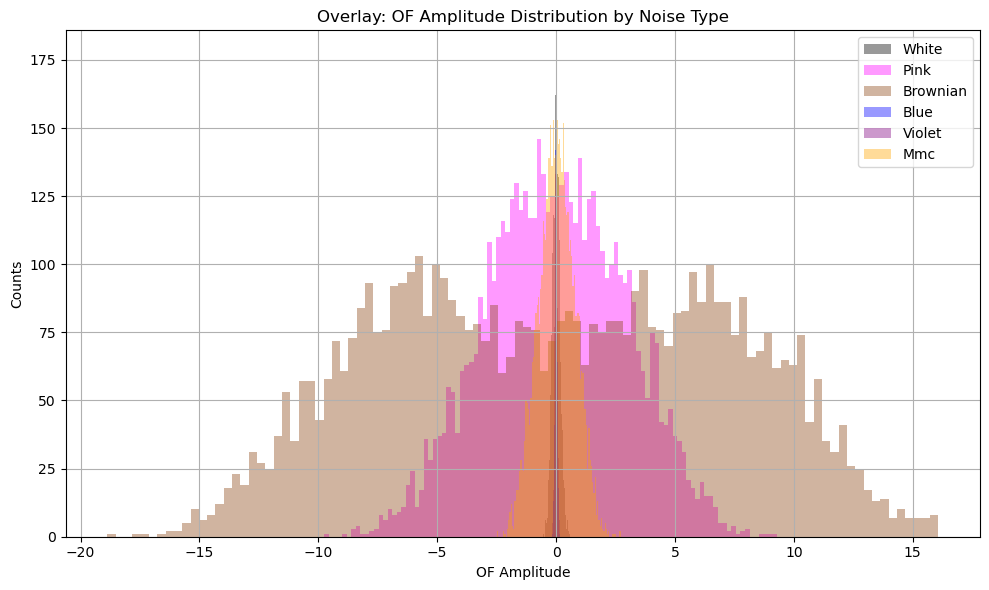

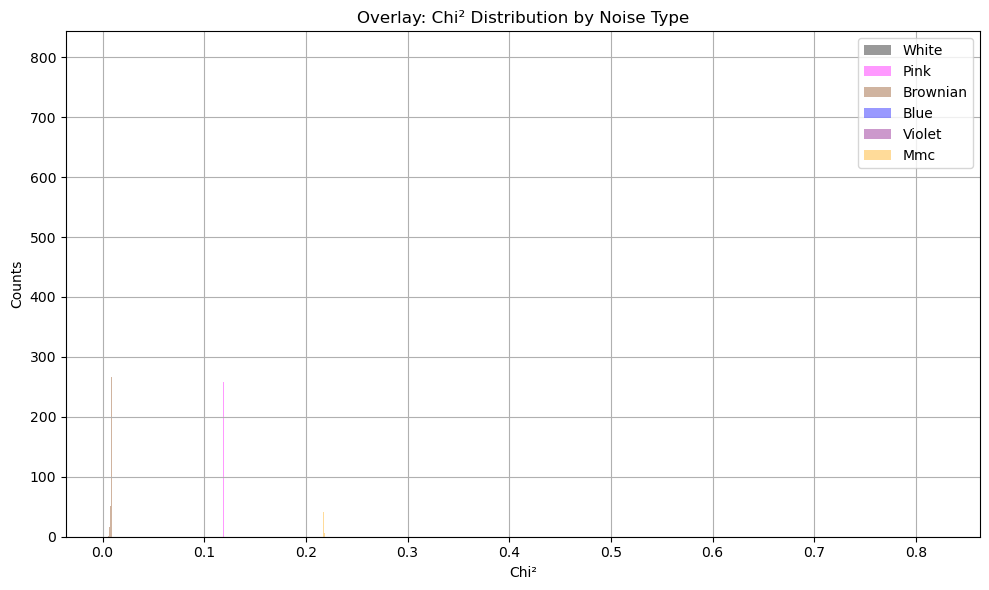

✅ Overlay plots (unnormalized) saved as PNG images.


In [33]:
# --- Overlay: OF Amplitudes ---
plt.figure(figsize=(10, 6))
for color, data in all_amplitudes.items():
    plt.hist(data, bins=100, alpha=0.4, label=color.capitalize(),
             color=plot_colors.get(color, 'gray'), edgecolor='none')  # removed density=True
plt.title("Overlay: OF Amplitude Distribution by Noise Type")
plt.xlabel("OF Amplitude")
plt.ylabel("Counts")  # changed from "Normalized Density"
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("overlay_of_amplitudes.png")
plt.show()

# --- Overlay: Chi² ---
plt.figure(figsize=(10, 6))
for color, data in all_chisq.items():
    plt.hist(data, bins=100, alpha=0.4, label=color.capitalize(),
             color=plot_colors.get(color, 'gray'), edgecolor='none')  # removed density=True
plt.title("Overlay: Chi² Distribution by Noise Type")
plt.xlabel("Chi²")
plt.ylabel("Counts")  # changed from "Normalized Density"
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("overlay_chisq.png")
plt.show()

print("✅ Overlay plots (unnormalized) saved as PNG images.")


In [34]:
path = "/ceph/dwong/trigger_samples/noise_traces/brownian_noise_traces.zst"
loaded_traces = load_traces_from_zstd(path, n_traces=n_sets)

In [35]:
loaded_traces.shape

(100, 54, 32768)

In [36]:
from tools import *

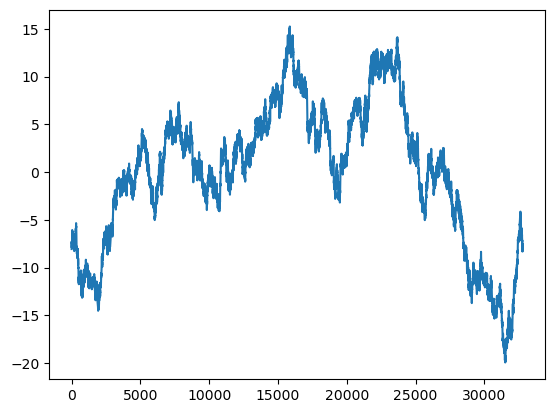

In [40]:
plt.plot(loaded_traces[10][27])

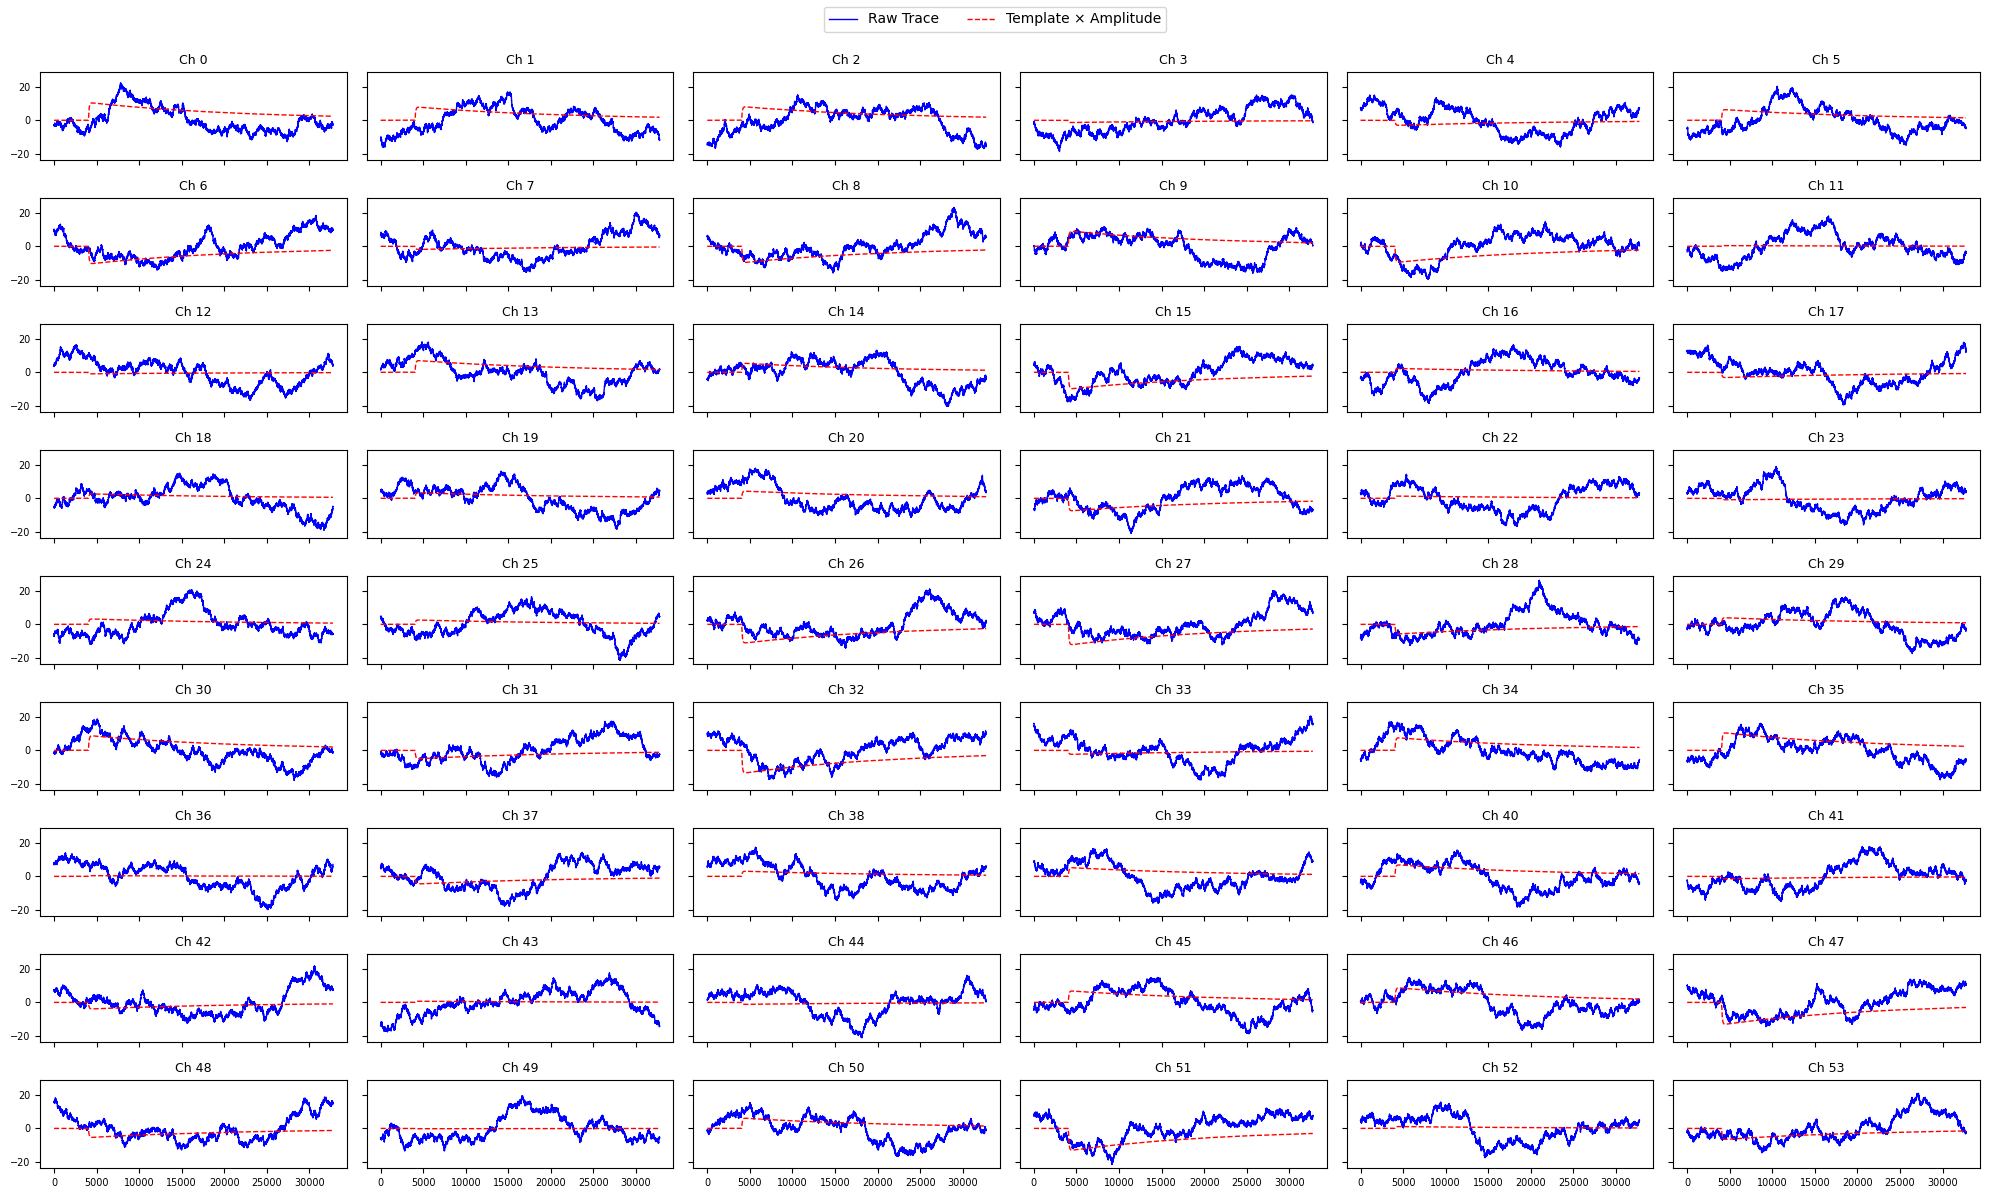

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from trace_IO import load_traces_from_zstd
from OF_trigger import *  # assumes `trigger` and `template` are available

sampling_frequency = 3906250


template = np.load("../templates/template_K_alpha_no_baseline.npy")
noise_psd = np.load("../templates/noise_psd_from_MMC.npy")
trace_path = "/ceph/dwong/trigger_samples/traces_energy_0.zst"
# Parameters

# Initialize Optimum Filter
trigger = OFtrigger(template, noise_psd, sampling_frequency)
# --- Load brownian noise traces ---
trace_file = "/ceph/dwong/trigger_samples/noise_traces/brownian_noise_traces.zst"
n_sets = 100  # Load just one (shape will be (1, 54, 32768))
trace_sets = load_traces_from_zstd(trace_file, n_traces=n_sets)
trace_set = trace_sets[0]  # Shape: (54, 32768)

# --- Compute OF amplitudes ---
of_amplitudes = []
for ch in range(54):
    of_val, _ = trigger.fit(trace_set[ch])
    of_amplitudes.append(of_val)
of_amplitudes = np.array(of_amplitudes)

# --- Get the OF template (must match trace length) ---

# --- Plotting function ---
def plot_trace_set_with_of(trace_set, amplitudes, template):
    """
    Plot all 54 channels of a single trace set with overlaid scaled OF template.
    """
    assert trace_set.shape[0] == 54, "Expected 54 channels"
    assert len(amplitudes) == 54, "Expected 54 amplitudes"
    assert trace_set.shape[1] == len(template), "Template length mismatch with trace length"

    fig, axs = plt.subplots(9, 6, figsize=(20, 12), sharex=True, sharey=True)
    axs = axs.flatten()

    for ch in range(54):
        trace = trace_set[ch]
        amp = amplitudes[ch]
        model = template * amp

        axs[ch].plot(trace, label='Raw Trace', color='blue', linewidth=1)
        axs[ch].plot(model, label='Template × Amplitude', color='red', linestyle='--', linewidth=1)
        axs[ch].set_title(f'Ch {ch}', fontsize=9)
        axs[ch].tick_params(labelsize=7)

    handles, labels = axs[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=10)

    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# --- Plot ---
plot_trace_set_with_of(trace_set, of_amplitudes, template)
